In [1]:
import os
from pathlib import Path

cwd = Path(os.getcwd())
print(cwd)` `
root = cwd.parent
os.chdir(root)
print(root)

c:\Users\hector.papoulias\Desktop\Docs\Repos\transaction_anomaly_detection\demos
c:\Users\hector.papoulias\Desktop\Docs\Repos\transaction_anomaly_detection


In [2]:
import seaborn as sns
sns.set_theme(style="whitegrid", palette="dark:#5A9_r")

# Synthetic Data Generation

The values of *categorical_feature_1* follow a uniform distribution:

\begin{equation}
\textit{categorical\_feature\_1} \sim \mathcal{U} \left( \{0,1,2,3,4,5\} \right)
\end{equation}

This holds for <span style="color: green;">normal</span> and <span style="color: red;">anomalous</span> datapoints alike.

In <span style="color: green;">normal</span> data points, *categorical_feature_2* is derived from *categorical feature_1* via:

\begin{equation}
  \textit{cat\_map\_normal} =
    \begin{cases}
      0 & \mapsto \mathrm{fraud}\\
      1 & \mapsto \mathrm{has}\\
      2 & \mapsto \mathrm{no}\\
      3 & \mapsto \mathrm{place}\\
      4 & \mapsto \mathrm{to}\\
      5 & \mapsto \mathrm{hide}
    \end{cases}       
\end{equation}

In <span style="color: red;">anomalous</span> datapoints, this mapping is distorted to:

\begin{equation}
  \textit{cat\_map\_anomaly} =
    \begin{cases}
      0 & \mapsto \mathrm{hide}\\
      1 & \mapsto \mathrm{fraud}\\
      2 & \mapsto \mathrm{fraud}\\
      3 & \mapsto \mathrm{fraud}\\
      4 & \mapsto \mathrm{fraud}\\
      5 & \mapsto \mathrm{fraud}
    \end{cases}       
\end{equation}

This is the most prevalent <span style="color: red;">anomaly</span> introduced in the synthetic dataset.

For <span style="color: green;">normal</span> data points, the values of *continuous_feature* follow:
\begin{equation}
\textit{continuous\_feature} \; \sim \: \mathcal{N}(0,1).
\end{equation}

For <span style="color: red;">anomalous</span> data points, they follow:
\begin{equation}
\textit{continuous\_feature} \; \sim \: \mathcal{N}(-0.1,0.0001).
\end{equation}

This <span style="color: red;">anomaly</span> is subtle: <span style="color: red;">anomalous</span> records have *continuous_feature* values misleadingly close to the <span style="color: green;">normal</span> record mean

In [3]:
import pandas as pd
import numpy as np

n_normal_datapoints = 10000
n_anomalous_datapoints = 100

np.random.seed(0)

# Generate in-distribution data
data_normal = {
    'continuous_feature': np.random.normal(loc=0, scale=0.1, size=n_normal_datapoints),
    'categorical_feature_1': np.random.randint(low=1, high=6, size=n_normal_datapoints)
}
df_normal = pd.DataFrame(data_normal)
df_normal['categorical_feature_1']=df_normal['categorical_feature_1'].apply(
    lambda x: str(x)
    )
cat_map_normal = {
    '0': 'fraud',
    '1': 'has',
    '2': 'no',
    '3': 'place',
    '4': 'to',
    '5': 'hide'
}
df_normal['categorical_feature_2']=df_normal['categorical_feature_1'].apply(
    lambda x: cat_map_normal[x]
    )
df_normal['anomaly']=False

# Generate out-of-distribution data
data_anomalies = {
    'continuous_feature': -0.1 + np.random.normal(loc=0, scale=0.0001, size=n_anomalous_datapoints),
    'categorical_feature_1': np.random.randint(low=1, high=6, size=n_anomalous_datapoints)
}
df_anomalies = pd.DataFrame(data_anomalies)
df_anomalies['categorical_feature_1']=df_anomalies['categorical_feature_1'].apply(
    lambda x: str(x)
    )
cat_map_anomaly = {
    '0': 'hide',
    '1': 'fraud',
    '2': 'fraud',
    '3': 'fraud',
    '4': 'fraud',
    '5': 'fraud'
}
df_anomalies['categorical_feature_2']=df_anomalies['categorical_feature_1'].apply(
    lambda x: cat_map_anomaly[x]
    )
df_anomalies['anomaly']=True

df=pd.concat([df_normal,df_anomalies]).reset_index(drop=True)
df.index = [f'record_{x}' for x in df.index.tolist()]
df

,continuous_feature,categorical_feature_1,categorical_feature_2,anomaly
record_0,0.176405,5,hide,False
record_1,0.040016,1,has,False
record_2,0.097874,5,hide,False
record_3,0.224089,2,no,False
record_4,0.186756,4,to,False
...,...,...,...,...
record_10095,-0.099882,5,fraud,True
record_10096,-0.099985,5,fraud,True
record_10097,-0.099960,2,fraud,True
record_10098,-0.099966,4,fraud,True


# Model Demo

## Initialization

In [5]:
from transaction_anomaly_detection.models import TransactionAnomalyDetector
import torch.nn as nn

anomaly_detector = TransactionAnomalyDetector(
    dict_cat_feature_to_ls_categories_n_embd={
    'categorical_feature_1': (['0', '1', '2', '3', '4', '5'], 4),
    'categorical_feature_2': (['fraud', 'has', 'no', 'place', 'to', 'hide'], 4)
        },
    ls_con_features= ['continuous_feature'],
    encoder_layer_szs=[512, 128, 32, 8],
    ae_activation=nn.LeakyReLU(0.01),
    dropout_rate=0.3,
    batchswap_noise_rate=0.4
    )

## Public Attributes

In [34]:
print('Autoencoder architecture: \n')
print(anomaly_detector.autoencoder_architecture)

Autoencoder architecture: 

Autoencoder(
  (_loss): ReconstructionLoss()
  (_batchswap_noise): BatchSwapNoise(swap_rate = 0.3)
  (_cat_preprocessor): ModuleDict(
    (embeddings): ModuleList(
      (0-1): 2 x Embedding(6, 4)
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (_con_preprocessor): ModuleDict(
    (normalizer): ContinuousFeatureNormalizer()
    (batch_norm): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (_standard_autoencoder): ModuleDict(
    (encoder): Sequential(
      (0): LinBnDrop(
        (_fc): Linear(in_features=9, out_features=512, bias=True)
        (_bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (_activation): LeakyReLU(negative_slope=0.01)
        (_dropout): Dropout(p=0.1, inplace=False)
      )
      (1): LinBnDrop(
        (_fc): Linear(in_features=512, out_features=128, bias=True)
        (_bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_

In [ ]:
print(f'n_params: {anomaly_detector.get_n_params()}')

In [35]:
print(f'Model has categorical features: {anomaly_detector.has_cat}')

Model has categorical features: True


In [36]:
print(f'Categorical features: {anomaly_detector.ls_cat_features}')

Categorical features: ['categorical_feature_1', 'categorical_feature_2']


In [37]:
print(f'Categories by categorical feature: {anomaly_detector.dict_cat_feature_to_ls_categories}')

Categories by categorical feature: {'categorical_feature_1': ['0', '1', '2', '3', '4', '5'], 'categorical_feature_2': ['fraud', 'has', 'no', 'place', 'to', 'hide']}


In [38]:
print(f'Embedding dimension by categorical feature: {anomaly_detector.dict_cat_feature_to_n_embd}')

Embedding dimension by categorical feature: {'categorical_feature_1': 4, 'categorical_feature_2': 4}


In [39]:
print(f'Model has continuous features: {anomaly_detector.has_con}')

Model has continuous features: True


In [40]:
print(f'Continuous features: {anomaly_detector.ls_con_features}')

Continuous features: ['continuous_feature']


In [41]:
print('Continuous feature statistics:')
anomaly_detector.df_con_stats
# The values presented are defaults.
# They are updated once the model is given access to data.

Continuous feature statistics:


,mean,std,min,max
continuous_feature,0,1,-1,1


In [42]:
print(f'Reconstruction Loss Threshold for Anomaly Detection: {anomaly_detector.reconstruction_loss_threshold}')

Reconstruction Loss Threshold for Anomaly Detection: nan


## Training

In [6]:
import numpy as np

dict_loss_evolution = anomaly_detector.fit(
    df_dataset=df,
    sz_batch=512,
    learning_rate=0.001,
    patience=100,
    loss_delta_threshold=0.001,
    max_n_epochs=np.inf,
    val_ratio=0.25,
    contamination=0.01,
    verbose=False
    )

Training:   0%|          | 0/1 [00:00<?, ?it/s]

Min Val Loss @Epoch 1181: 0.6699737851867242 


In [7]:
print('Continuous feature statistics:')
anomaly_detector.df_con_stats

Continuous feature statistics:


,mean,std,min,max
continuous_feature,-0.002815,0.098745,-0.37401,0.380166


In [8]:
print(f'Reconstruction Loss Threshold for Anomaly Detection: {anomaly_detector.reconstruction_loss_threshold}')

Reconstruction Loss Threshold for Anomaly Detection: 1.8044028537329933


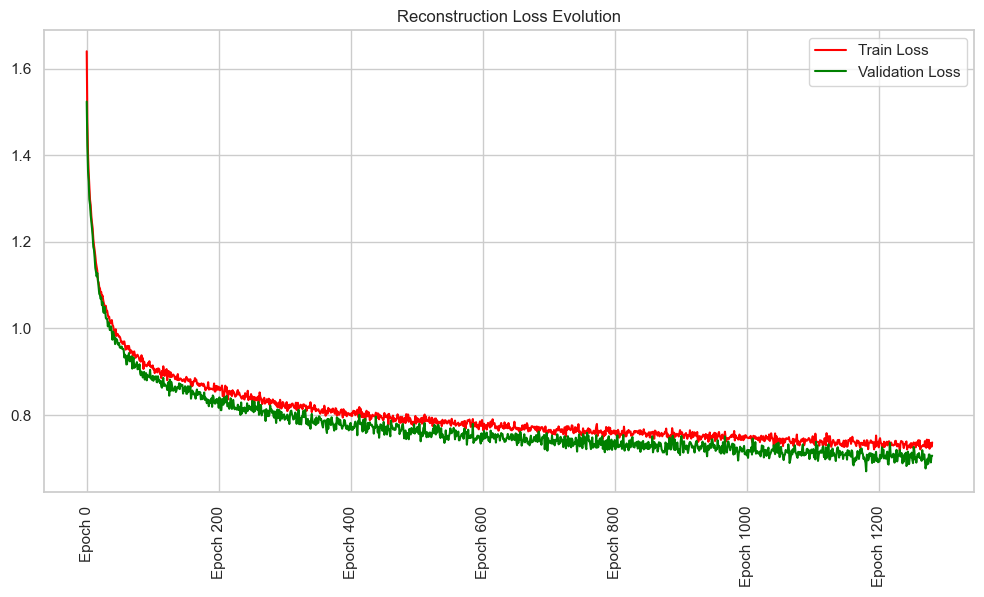

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

fig, ax = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(12,6)
)

dict_loss_evolution['train'].plot(ax = ax, rot=90, color='red')
dict_loss_evolution['val'].plot(ax = ax, rot=90, color='green')

plt.title('Reconstruction Loss Evolution')
plt.legend(["Train Loss", "Validation Loss"])


## Refitting the Reconstruction Loss Threshold

In [27]:
anomaly_detector.fit_reconstruction_loss_threshold(
    df_dataset=df,
    contamination=0.01
    )
print(f'Reconstruction Loss Threshold for Anomaly Detection: {anomaly_detector.reconstruction_loss_threshold}')

Reconstruction Loss Threshold for Anomaly Detection: 1.8044028537329933


## Reconstruction Loss Computations

In [10]:
df_records_for_loss_computation = df.iloc[:5,:]

df_records_for_loss_computation

,continuous_feature,categorical_feature_1,categorical_feature_2,anomaly
record_0,0.176405,5,hide,False
record_1,0.040016,1,has,False
record_2,0.097874,5,hide,False
record_3,0.224089,2,no,False
record_4,0.186756,4,to,False


In [11]:
df_loss_by_record = anomaly_detector.compute_reconstruction_loss_by_record(df_records_for_loss_computation)

df_loss_by_record

,categorical_feature_1,categorical_feature_2,continuous_feature
record_0,0.719656,1.248266,0.132761
record_1,0.443704,0.883409,0.165393
record_2,0.639035,1.197025,0.025025
record_3,0.973244,1.412813,0.790042
record_4,0.619812,0.533180,0.025669


In [12]:
sr_loss_by_record = anomaly_detector.compute_reconstruction_loss_by_record(
    df_records_for_loss_computation,
    average_over_features=True
    )
    
sr_loss_by_record

record_0    0.700228
record_1    0.497502
record_2    0.620362
record_3    1.058700
record_4    0.392887
dtype: float64

In [13]:
sr_loss_by_feature = anomaly_detector.compute_reconstruction_loss_by_feature(df_records_for_loss_computation)

sr_loss_by_feature

categorical_feature_2    1.054939
categorical_feature_1    0.679090
continuous_feature       0.227778
dtype: float64

In [14]:
mean_loss = anomaly_detector.compute_mean_reconstruction_loss(df_records_for_loss_computation)
print('Mean reconstruction loss---average over records, then average over features---:')
print(mean_loss)

Mean reconstruction loss---average over records, then average over features---:
0.6539356868956684


## Encodings (Latent Space Representations)

In [15]:
original_records = df
t_encoded_records = anomaly_detector.encode(original_records)

t_encoded_records # t_encoded_records shape: (n_input_records, dim_latent_rep)

tensor([[-0.0028, -0.0086,  0.0711,  ...,  0.1375, -0.0020, -0.0019],
        [-0.0039,  0.2057, -0.0028,  ...,  0.1241, -0.0050, -0.0055],
        [-0.0041,  0.1287,  0.1044,  ...,  0.2027, -0.0027, -0.0025],
        ...,
        [ 0.6445,  0.3131, -0.0174,  ..., -0.0099, -0.0100, -0.0110],
        [-0.0200,  0.5658,  0.3533,  ...,  0.6931, -0.0115, -0.0112],
        [-0.0200,  0.5658,  0.3534,  ...,  0.6931, -0.0115, -0.0112]])

## Reconstructions

In [16]:
original_data = df.iloc[10:15,:]

reconstructed_data = anomaly_detector.reconstruct(original_data)

display(original_data)
print('\n')
display(reconstructed_data)

,continuous_feature,categorical_feature_1,categorical_feature_2,anomaly
record_10,0.014404,3,place,False
record_11,0.145427,5,hide,False
record_12,0.076104,4,to,False
record_13,0.012168,5,hide,False
record_14,0.044386,5,hide,False


,continuous_feature_recon,categorical_feature_1_recon,categorical_feature_2_recon
record_10,0.086449,3,place
record_11,0.135612,5,has
record_12,0.152447,4,to
record_13,0.089000,5,hide
record_14,0.099760,5,hide


In [17]:
original_data = df.iloc[0]

reconstructed_data = anomaly_detector.reconstruct(original_data)

display(original_data)
print('\n')
display(reconstructed_data)

continuous_feature       0.176405
categorical_feature_1           5
categorical_feature_2        hide
anomaly                     False
Name: record_0, dtype: object

,continuous_feature_recon,categorical_feature_1_recon,categorical_feature_2_recon
record_0,0.140426,5,has


## Anomaly Detection

In [28]:
df_anomalies = anomaly_detector.detect_anomalies(df)
df_anomalies

,loss,index,continuous_feature,categorical_feature_1,categorical_feature_2,anomaly
loss_rank,,,,,,
0,2.948409,record_3752,-0.374010,1,has,False
1,2.495096,record_6727,-0.306921,2,no,False
2,2.485341,record_3679,-0.339230,1,has,False
3,2.403594,record_4469,-0.300744,2,no,False
4,2.363210,record_8457,-0.297975,2,no,False
...,...,...,...,...,...,...
96,1.804536,record_10007,-0.100108,3,fraud,True
97,1.804532,record_10045,-0.100104,3,fraud,True
98,1.804498,record_10066,-0.100078,3,fraud,True


In [29]:
idx_anom = df_anomalies['index'].tolist()
n_tp = len(df_anomalies[df_anomalies['anomaly'] == True])
n_fp = len(df_anomalies[df_anomalies['anomaly'] == False])
n_tn = len(df[(~df.index.isin(idx_anom)) & (df['anomaly']==False)])
n_fn = len(df[(~df.index.isin(idx_anom)) & (df['anomaly']==True)])

precision = n_tp/(n_tp + n_fp)
recall = n_tp/(n_tp + n_fn)
f1=2*precision*recall/(precision+recall)

print('Anomaly Detection Evaluation:')

print('\n')
print(f'n_tp: {n_tp}')
print(f'n_fp: {n_fp}')
print(f'n_tn: {n_tn}')
print(f'n_fn: {n_fn}')

print('\n')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1: {f1}')

Anomaly Detection Evaluation:


n_tp: 70
n_fp: 31
n_tn: 9969
n_fn: 30


precision: 0.693069306930693
recall: 0.7
f1: 0.6965174129353233


In [31]:
anomaly_detector.compute_reconstruction_loss_by_feature(df[df['anomaly'] == False])

continuous_feature       0.877379
categorical_feature_2    0.681765
categorical_feature_1    0.334016
dtype: float64

In [32]:
anomaly_detector.compute_reconstruction_loss_by_feature(df[df['anomaly'] == True])

categorical_feature_2    3.728619
continuous_feature       1.514277
categorical_feature_1    0.400242
dtype: float64

The model ranks the features by <span style="color: red;">anomaly risk</span> as follows:

<span style="color: red;">*categorical_feature_2*</span> is the most suspicious,

<span style="color: orange;">*continuous_feature*</span> comes in second,

<span style="color: green;">*categorical_feature_1*</span> comes in last, with a clear separation from the rest.

Recalling the data generation procdeudre, this is to be expected.

In <span style="color: green;">normal</span> records, *categorical_feature_2* was derived from *categorical_feature_1* using a fixed mapping.
In <span style="color: red;">anomalous</span> data, this mapping was distorted. This was indeed the primary <span style="color: red;">anomaly</span> introduced in the synthetic dataset.

<span style="color: red;">Anomalous</span> records also had their *continuous_feature* values distorted. Recall however, that this distortion was subtle.
Rather than being sampled from $\mathcal{N(0,1)}$---as in <span style="color: green;">normal</span> data---<span style="color: red;">anomalous</span> values were sampled from $\mathcal{N(-0.1, 0.0001)}$. The data misleadingly appears in-distribution: outlier detection methods conditioning on zscores/ MAD would not work. The model detects the <span style="color: red;">anomaly</span> and---as expected---reacts to it less strongly than it did to the categorical mapping distortion.

The model considers *categorical_feature_1* to be <span style="color: green;">anomaly-free</span>. Indeed, the data generation procedure was the same for <span style="color: red;">normal</span> and <span style="color: red;">anomalous</span> records alike.